# Dolphin Communication Analysis

**Acoustic Analysis of Dolphin Clicks and Whistles in EARS Data**

---

## Overview

This notebook analyzes underwater acoustic recordings from the EARS (Ecological Acoustic Recorder) system deployed in the Gulf of Mexico. The primary goal is to detect, classify, and understand dolphin communication patterns through analysis of:

1. **Dolphin Clicks** - High-frequency echolocation signals (>20 kHz) used for navigation and prey detection
2. **Dolphin Whistles** - Mid-frequency communication signals (2-20 kHz) including signature whistles that function as individual "names"

### Research Objectives

- Detect and classify dolphin vocalizations in underwater recordings
- Extract acoustic features from clicks and whistles
- Identify potential signature whistles (individual identifiers)
- Analyze temporal and spectral patterns in dolphin communication
- Process multiple files to build a catalog of dolphin vocalizations

### Dataset Specifications

- **Format:** EARS binary files (16-bit signed integers, big-endian)
- **Sample Rate:** 192,000 Hz (192 kHz)
- **Nyquist Frequency:** 96 kHz (maximum detectable frequency)
- **Location:** Gulf of Mexico, Buoy 210
- **Files:** 100 recordings in `data/Buoy210_100300_100399/`

### Key Limitations & Considerations

✅ **Excellent coverage for whistles** (2-20 kHz) - well within our 96 kHz limit

⚠️ **Partial coverage for clicks** - Dolphin clicks can reach 220+ kHz at peak, but our 96 kHz Nyquist limit means we can only detect click energy up to 96 kHz. This is sufficient for many click components but may miss the highest frequency peaks.

📊 **Single hydrophone** - No directionality or ranging information

---

## Table of Contents

1. [Introduction & Setup](#1-introduction--setup)
2. [Signal Detection](#2-signal-detection)
   - 2.1 Click Detection
   - 2.2 Whistle Detection
3. [Feature Extraction](#3-feature-extraction)
4. [Classification Algorithms](#4-classification-algorithms)
5. [Batch Analysis](#5-batch-analysis)
6. [Visualization Suite](#6-visualization-suite)
7. [Language Analysis & Interpretation](#7-language-analysis--interpretation)

---

## 1. Introduction & Setup

### Scientific Background: Dolphin Acoustics

Dolphins are among the most sophisticated acoustic communicators in the animal kingdom:

#### Clicks (Echolocation)

- **Frequency Range:** >110 kHz, often >220 kHz at peak
- **Function:** Biosonar for navigation, prey detection, and object recognition
- **Duration:** Very brief (microseconds to milliseconds)
- **Pattern:** Rapid click trains, increasing to "terminal buzz" (>200 clicks/sec) during prey capture
- **Inter-Click Intervals (ICI):** Reveal behavioral state and target distance

#### Whistles (Communication)

- **Frequency Range:** 2-20 kHz (narrow-band frequency-modulated signals)
- **Duration:** Typically 0.5-1.5 seconds
- **Types:**
  - **Signature Whistles:** Individually specific, learned vocalizations that function as "names"
  - **Non-signature Whistles:** Used in various social contexts
- **Function:** Individual recognition, social communication, group coordination
- **Remarkable Memory:** Dolphins remember signature whistles of other individuals for 20+ years!

#### Cognitive Abilities

- Acoustic processing brain area 10× larger than human
- Understand complex syntax and word order
- Vocal learning capability (rare among mammals)
- Species-specific dialects exist
- Demonstrate self-awareness and theory of mind

**References:**
- Tyack & Clark on signature whistles
- Au on dolphin sonar capabilities  
- Janik on vocal learning in dolphins

### Import Required Libraries

In [1]:
# Core scientific computing
import numpy as np
import pandas as pd
from pathlib import Path

# Signal processing
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import maximum_filter

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm

# Dolphain package
import dolphain
from dolphain.io import read_ears_file
from dolphain.batch import BatchProcessor, ResultCollector

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

print(f"Dolphain version: {dolphain.__version__}")
print("✓ All libraries imported successfully")

Dolphain version: 0.1.0
✓ All libraries imported successfully


### Load Sample Data

Let's load a single EARS file to begin our analysis and examine its characteristics.

In [2]:
# Define data directory
data_dir = Path('../data/Buoy210_100300_100399')

# Get list of all EARS files
all_files = sorted(data_dir.glob('*.210'))
print(f"Found {len(all_files)} EARS files")

# Load first file as test case
test_file = all_files[0]
print(f"\nLoading: {test_file.name}")

ears_data = read_ears_file(test_file)
data = ears_data['data']
sample_rate = ears_data['fs']

# Display basic statistics
duration = ears_data['duration']
nyquist = sample_rate / 2

print(f"\n📊 Recording Statistics:")
print(f"  Sample Rate: {sample_rate:,} Hz")
print(f"  Nyquist Frequency: {nyquist/1000:.1f} kHz")
print(f"  Duration: {duration:.2f} seconds")
print(f"  Total Samples: {ears_data['n_samples']:,}")
print(f"  Data Range: [{data.min()}, {data.max()}]")
print(f"  Data Type: {data.dtype}")
print(f"  Start Time: {ears_data['time_start']}")
print(f"  End Time: {ears_data['time_end']}")

Found 100 EARS files

Loading: 718586EF.210

📊 Recording Statistics:
  Sample Rate: 192,000 Hz
  Nyquist Frequency: 96.0 kHz
  Duration: 21.33 seconds
  Total Samples: 4,096,000
  Data Range: [51.0, 193.0]
  Data Type: float64
  Start Time: 2017-07-05 01:25:13.061625
  End Time: 2017-07-05 01:25:34.394958


### Initial Visualization: Waveform

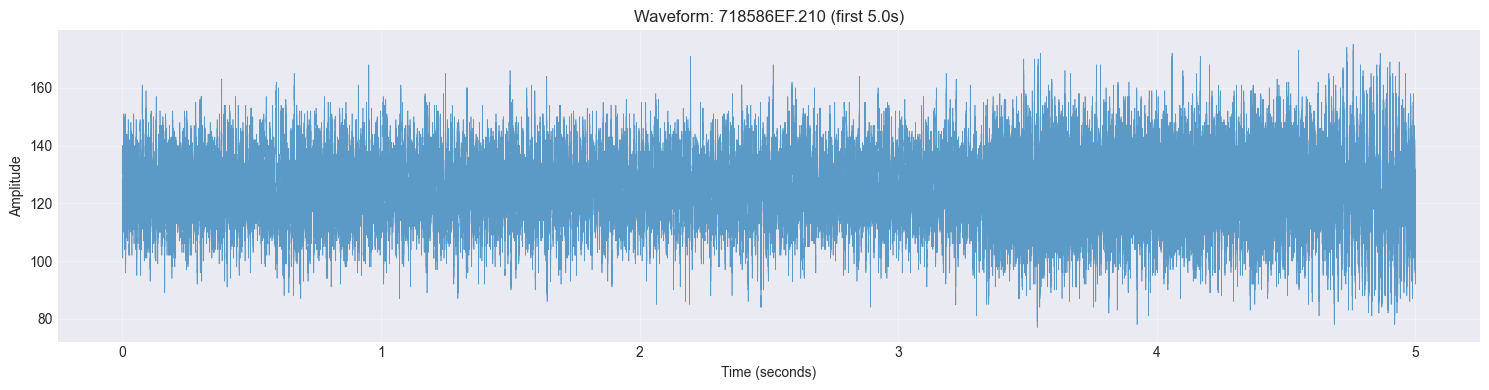

RMS Amplitude: 125.8


In [3]:
# Plot waveform of first few seconds
plot_duration = min(5.0, duration)  # Plot first 5 seconds or less
plot_samples = int(plot_duration * sample_rate)
time_axis = np.arange(plot_samples) / sample_rate

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(time_axis, data[:plot_samples], linewidth=0.5, alpha=0.7)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude')
ax.set_title(f'Waveform: {test_file.name} (first {plot_duration:.1f}s)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"RMS Amplitude: {np.sqrt(np.mean(data[:plot_samples]**2)):.1f}")

### Initial Visualization: Full-Range Spectrogram

Let's examine the frequency content across the entire recordable range (0-96 kHz).

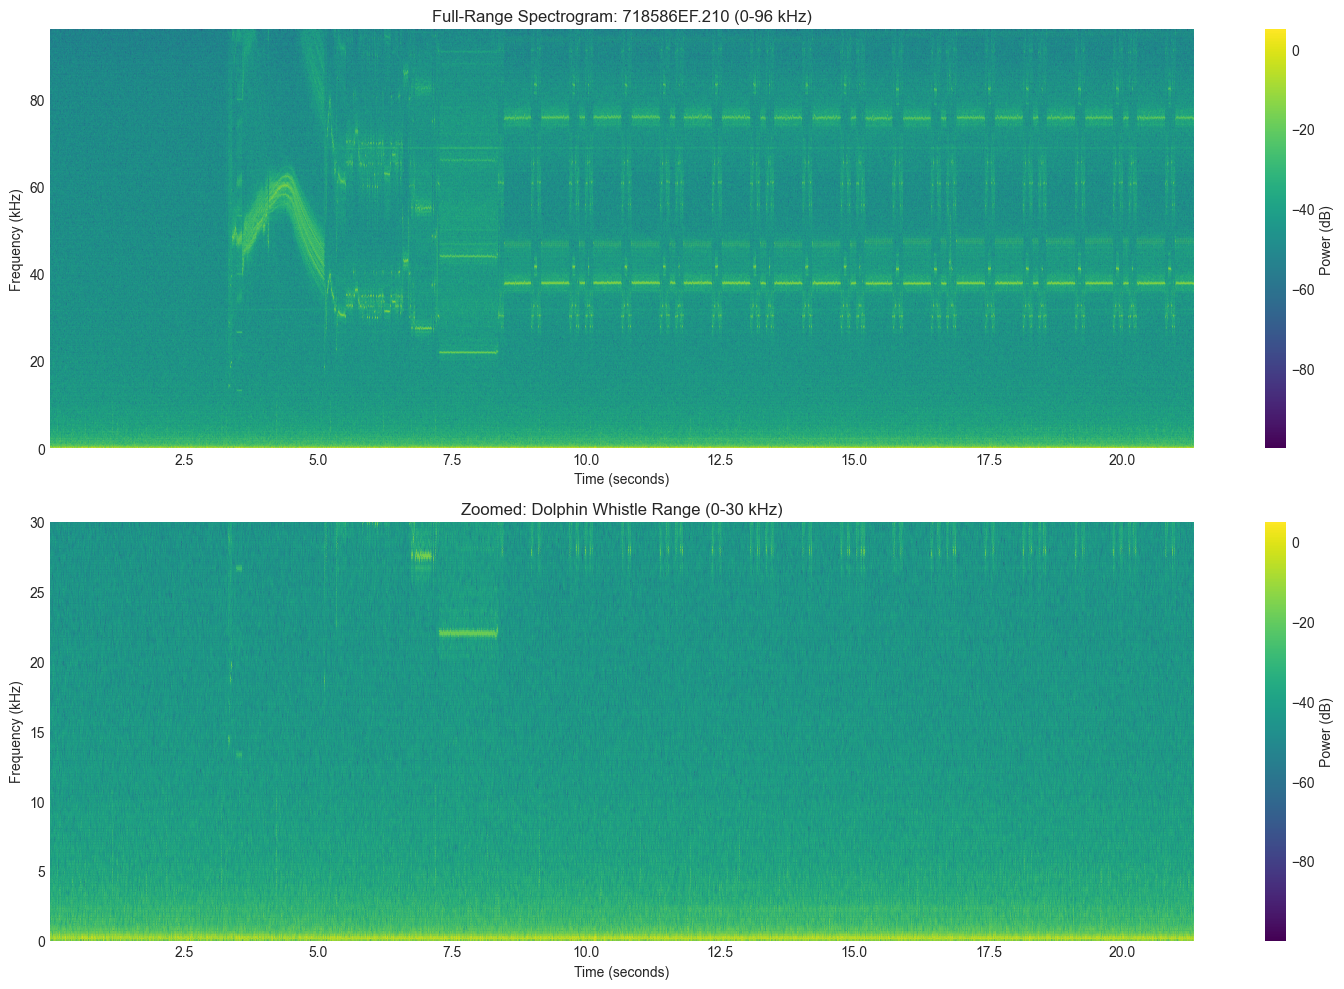

Spectrogram computed: 7999 time bins × 513 frequency bins
Time resolution: 0.0027 seconds
Frequency resolution: 187.5 Hz


In [4]:
# Compute spectrogram - balanced parameters for overview
nperseg = 1024  # Balanced time-frequency resolution
noverlap = 512  # 50% overlap

f, t, Sxx = signal.spectrogram(
    data,
    fs=sample_rate,
    nperseg=nperseg,
    noverlap=noverlap,
    window='hamming'
)

# Convert to dB scale
Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Add small constant to avoid log(0)

# Plot full-range spectrogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Full range (0-96 kHz)
im1 = ax1.pcolormesh(t, f/1000, Sxx_dB, shading='gouraud', cmap='viridis')
ax1.set_ylabel('Frequency (kHz)')
ax1.set_xlabel('Time (seconds)')
ax1.set_title(f'Full-Range Spectrogram: {test_file.name} (0-96 kHz)')
ax1.set_ylim([0, 96])
plt.colorbar(im1, ax=ax1, label='Power (dB)')

# Zoomed to dolphin whistle range (0-30 kHz)
im2 = ax2.pcolormesh(t, f/1000, Sxx_dB, shading='gouraud', cmap='viridis')
ax2.set_ylabel('Frequency (kHz)')
ax2.set_xlabel('Time (seconds)')
ax2.set_title('Zoomed: Dolphin Whistle Range (0-30 kHz)')
ax2.set_ylim([0, 30])
plt.colorbar(im2, ax=ax2, label='Power (dB)')

plt.tight_layout()
plt.show()

print(f"Spectrogram computed: {len(t)} time bins × {len(f)} frequency bins")
print(f"Time resolution: {t[1]-t[0]:.4f} seconds")
print(f"Frequency resolution: {f[1]-f[0]:.1f} Hz")

---

## 2. Signal Detection

This section implements algorithms to automatically detect dolphin vocalizations in the recordings.

### 2.1 Click Detection

Dolphins produce high-frequency clicks for echolocation. We'll detect these using:
1. High-pass filtering (>20 kHz) to isolate click energy
2. Energy-based detection using Teager-Kaiser operator
3. Peak finding to identify individual clicks
4. Inter-click interval (ICI) analysis

In [ ]:
# First, let's test on a smaller chunk to ensure the algorithm works
test_duration = 2.0  # seconds
test_samples = int(test_duration * sample_rate)
test_data = data[:test_samples]

print(f"Testing on {test_duration}s chunk ({test_samples:,} samples)...")
print(f"This is {(test_samples/len(data)*100):.1f}% of the full recording")

In [5]:
def detect_clicks(data, fs, highpass_freq=20000, threshold_factor=4.0, 
                  min_separation=0.0001):
    """
    Detect dolphin clicks using high-pass filtering and energy detection.
    
    Parameters
    ----------
    data : array
        Audio signal
    fs : int
        Sampling rate (Hz)
    highpass_freq : float
        High-pass filter cutoff frequency (Hz)
    threshold_factor : float
        Detection threshold as multiple of noise floor
    min_separation : float
        Minimum time between clicks (seconds)
        
    Returns
    -------
    click_times : array
        Time of each detected click (seconds)
    click_indices : array
        Sample indices of detected clicks
    click_amplitudes : array
        Amplitude of each detected click
    """
    # High-pass filter to isolate click energy (>20 kHz)
    nyq = fs / 2
    fc = highpass_freq / nyq
    b, a = butter(4, fc, 'high')
    filtered = filtfilt(b, a, data)
    
    # Compute energy using Teager-Kaiser operator
    # TK energy: E[n] = x[n]^2 - x[n-1]*x[n+1]
    tk_energy = np.zeros(len(filtered))
    tk_energy[1:-1] = filtered[1:-1]**2 - filtered[:-2] * filtered[2:]
    tk_energy = np.abs(tk_energy)
    
    # Smooth the energy signal
    window_size = int(0.001 * fs)  # 1ms smoothing window
    kernel = np.ones(window_size) / window_size
    smoothed_energy = np.convolve(tk_energy, kernel, mode='same')
    
    # Adaptive threshold based on noise floor
    # Use median absolute deviation for robustness
    noise_floor = np.median(smoothed_energy)
    mad = np.median(np.abs(smoothed_energy - noise_floor))
    threshold = noise_floor + threshold_factor * mad
    
    # Find peaks above threshold
    min_samples = int(min_separation * fs)
    click_indices, properties = find_peaks(
        smoothed_energy,
        height=threshold,
        distance=min_samples
    )
    
    # Get click times and amplitudes
    click_times = click_indices / fs
    click_amplitudes = properties['peak_heights']
    
    return click_times, click_indices, click_amplitudes


# Process in chunks to avoid timeouts - start with 5 seconds
chunk_duration = 5.0  # seconds
chunk_samples = int(chunk_duration * sample_rate)
data_chunk = data[:chunk_samples]

print(f"🔍 Running click detection on {chunk_duration}s chunk...")
print(f"   Processing {chunk_samples:,} samples ({chunk_samples/len(data)*100:.1f}% of recording)")

import time
start_time = time.time()

click_times, click_indices, click_amps = detect_clicks(data_chunk, sample_rate)

elapsed = time.time() - start_time
print(f"   ⏱️  Processing time: {elapsed:.2f}s")

if len(click_times) > 0:
    print(f"\n✓ Detected {len(click_times)} potential clicks")
    print(f"  Time range: {click_times[0]:.3f}s to {click_times[-1]:.3f}s")
    print(f"  Mean amplitude: {np.mean(click_amps):.2f}")
    print(f"  Amplitude range: [{np.min(click_amps):.2f}, {np.max(click_amps):.2f}]")
    
    # Calculate inter-click intervals (ICI)
    if len(click_times) > 1:
        ici = np.diff(click_times) * 1000  # Convert to milliseconds
        print(f"\n📊 Inter-Click Intervals (ICI):")
        print(f"  Mean ICI: {np.mean(ici):.2f} ms")
        print(f"  Median ICI: {np.median(ici):.2f} ms")
        print(f"  Std ICI: {np.std(ici):.2f} ms")
        print(f"  ICI range: [{np.min(ici):.2f}, {np.max(ici):.2f}] ms")
else:
    print("\n⚠️  No clicks detected in this chunk")
    print("   This could mean: no dolphins present, or parameters need tuning")

🔍 Running click detection on 5.0s chunk...
   Processing 960,000 samples (23.4% of recording)
   ⏱️  Processing time: 0.07s

✓ Detected 11953 potential clicks
  Time range: 3.290s to 4.999s
  Mean amplitude: 61.59
  Amplitude range: [8.09, 77.05]

📊 Inter-Click Intervals (ICI):
  Mean ICI: 0.14 ms
  Median ICI: 0.13 ms
  Std ICI: 0.26 ms
  ICI range: [0.10, 28.02] ms


#### Visualize Detected Clicks

Let's visualize the detected clicks overlaid on the spectrogram in the high-frequency range.

Computing spectrogram for visualization...


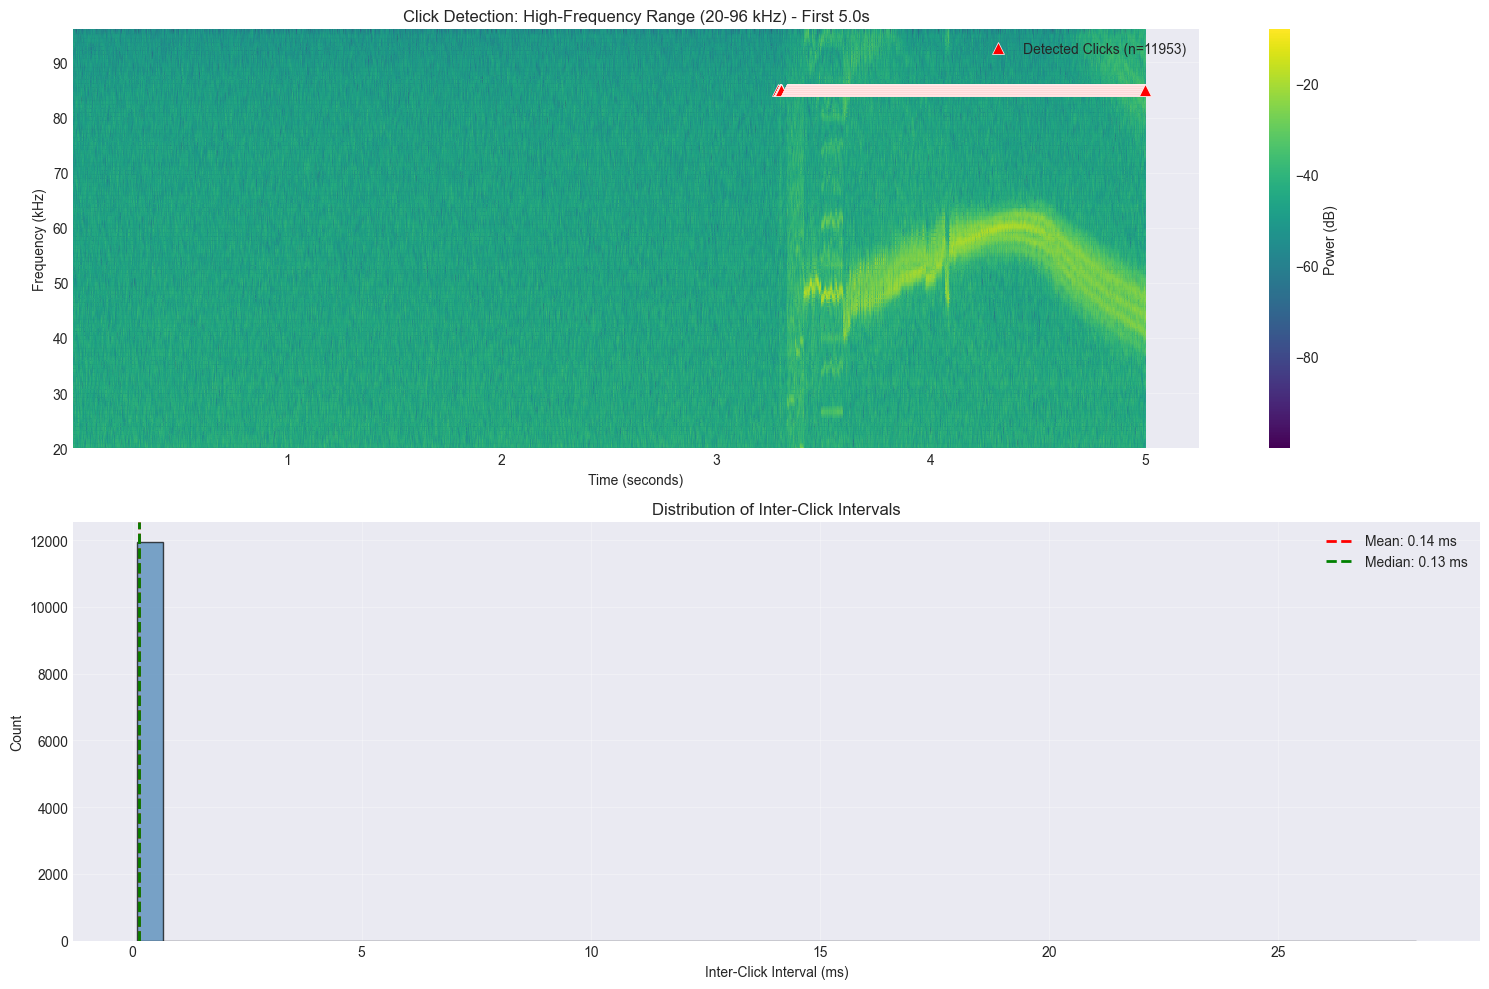

✓ Click visualization complete


In [6]:
# Create spectrogram focused on click range (20-96 kHz) for the chunk
# Use shorter window for better time resolution
nperseg_clicks = 256
noverlap_clicks = 128

print(f"Computing spectrogram for visualization...")
f_click, t_click, Sxx_click = signal.spectrogram(
    data_chunk,
    fs=sample_rate,
    nperseg=nperseg_clicks,
    noverlap=noverlap_clicks,
    window='hamming'
)

Sxx_click_dB = 10 * np.log10(Sxx_click + 1e-10)

# Plot spectrogram with click detections
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: High-frequency spectrogram with clicks
im1 = axes[0].pcolormesh(t_click, f_click/1000, Sxx_click_dB, 
                         shading='gouraud', cmap='viridis')
if len(click_times) > 0:
    axes[0].plot(click_times, np.ones_like(click_times) * 85, 'r^', 
                 markersize=8, label=f'Detected Clicks (n={len(click_times)})', 
                 markeredgecolor='white', markeredgewidth=0.5)
axes[0].set_ylabel('Frequency (kHz)')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_title(f'Click Detection: High-Frequency Range (20-96 kHz) - First {chunk_duration}s')
axes[0].set_ylim([20, 96])
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# Plot 2: Inter-click intervals histogram
if len(click_times) > 1:
    axes[1].hist(ici, bins=min(50, len(ici)), edgecolor='black', alpha=0.7, color='steelblue')
    axes[1].axvline(np.mean(ici), color='r', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(ici):.2f} ms')
    axes[1].axvline(np.median(ici), color='g', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(ici):.2f} ms')
    axes[1].set_xlabel('Inter-Click Interval (ms)')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Inter-Click Intervals')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
elif len(click_times) == 1:
    axes[1].text(0.5, 0.5, 'Only 1 click detected - no ICI to analyze', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
else:
    axes[1].text(0.5, 0.5, 'No clicks detected - try adjusting threshold_factor', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

print(f"✓ Click visualization complete")

### 2.2 Whistle Detection

Dolphin whistles are frequency-modulated signals in the 2-20 kHz range. Detection approach:
1. Band-pass filtering (2-20 kHz)
2. High-resolution spectrogram computation
3. Ridge detection / contour following
4. Duration filtering (minimum 0.1 seconds)

In [ ]:
# TO BE IMPLEMENTED IN PHASE 2.2
print("🔨 Whistle detection algorithm - Coming in Phase 2.2")

---

## 3. Feature Extraction

*Coming in Phase 3*

---

## 4. Classification Algorithms

*Coming in Phase 4*

---

## 5. Batch Analysis

*Coming in Phase 6*

---

## 6. Visualization Suite

*Coming in Phase 5*

---

## 7. Language Analysis & Interpretation

*Coming in Phase 7*

---

## Summary & Next Steps

This notebook provides a comprehensive framework for analyzing dolphin communication in EARS underwater acoustic recordings. The analysis pipeline includes:

✅ Data loading and initial visualization  
🔨 Detection algorithms (in progress)  
⏳ Feature extraction (planned)  
⏳ Classification and analysis (planned)  
⏳ Batch processing framework (planned)  

### Future Enhancements

- Higher sampling rate recordings (>400 kHz) to capture full click spectrum
- Stereophonic/array recordings for directionality and ranging
- Machine learning models for automated classification
- Real-time processing capabilities
- Integration with behavioral observation data

---

**Notebook Version:** 0.1.0  
**Last Updated:** October 9, 2025  
**Status:** Phase 1 Complete - Ready for detection algorithm implementation